# Get current Starbucks menu

#### Load Python tools and Jupyter config

In [100]:
import json
import requests
import numpy as np
import pandas as pd
import jupyter_black
import altair as alt
import plotly.express as px
import matplotlib.pyplot as plt

In [31]:
jupyter_black.load()
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = None

In [32]:
today = pd.Timestamp("today").strftime("%Y%m%d")

---

## Read data

#### Headers for request

In [33]:
headers = {
    "authority": "www.starbucks.com",
    "accept": "application/json",
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
    "x-requested-with": "XMLHttpRequest",
}

#### Get response

In [ ]:
response = requests.get("https://www.starbucks.com/bff/ordering/menu", headers=headers)
json_data = response.json()["menus"]

#### Function for dealing with nested json

In [ ]:
def flatten_structure(entries, path=None, level=0):
    if path is None:
        path = []
    flattened_data = []

    for entry in entries:
        current_path = path + [entry.get("name", "")]
        extended_path = current_path + [""] * (3 - len(current_path))

        # Process products in the current entry
        for product in entry.get("products", []):
            product_info = {
                "main_category": extended_path[0] if len(extended_path) > 0 else "",
                "sub_category": extended_path[1] if len(extended_path) > 1 else "",
                "category_detail": extended_path[2] if len(extended_path) > 2 else "",
                "product_name": product.get("name"),
                "product_form": product.get("formCode"),
                "display_order": product.get("displayOrder"),
                "product_number": product.get("productNumber"),
                "product_type": product.get("productType"),
                "availability": product.get("availability"),
                "path": product.get("uri"),
                "sizes": [size.get("sizeCode") for size in product.get("sizes", [])],
            }
            flattened_data.append(product_info)

        if "children" in entry:
            flattened_data.extend(
                flatten_structure(entry["children"], path=current_path, level=level + 1)
            )

    return flattened_data

#### Apply the function to the data

In [37]:
flattened_data = flatten_structure(json_data)

#### Convert the flattened data to a DataFrame

In [125]:
df = pd.DataFrame(flattened_data)

In [236]:
df.head()

,main_category,sub_category,category_detail,product_name,product_form,display_order,product_number,product_type,path,sizes
0,Drinks,Oleato™,,Oleato Golden Foam™ Iced Shaken Espresso with Toffeenut,Iced,1,2123803,Beverage,/product/2123803/iced,"[Tall, Grande, Venti]"
1,Drinks,Oleato™,,Oleato™ Caffé Latte with Oatmilk,Hot,4,2123744,Beverage,/product/2123744/hot,"[Short, Tall, Grande, Venti]"
2,Drinks,Oleato™,,Iced Chai Tea Latte with Oleato Golden Foam™,Iced,6,2123780,Beverage,/product/2123780/iced,"[Tall, Grande, Venti]"
3,Drinks,Oleato™,,Iced Matcha Tea Latte with Oleato Golden Foam™,Iced,7,2123781,Beverage,/product/2123781/iced,"[Tall, Grande, Venti]"
4,Drinks,Oleato™,,Paradise Drink Starbucks Refreshers® Beverage with Oleato Golden Foam™,Iced,8,2123779,Beverage,/product/2123779/iced,"[Tall, Grande, Venti, Trenta]"


In [ ]:
len(df)

---

## Charts

#### Products by categories in a sunburst chart

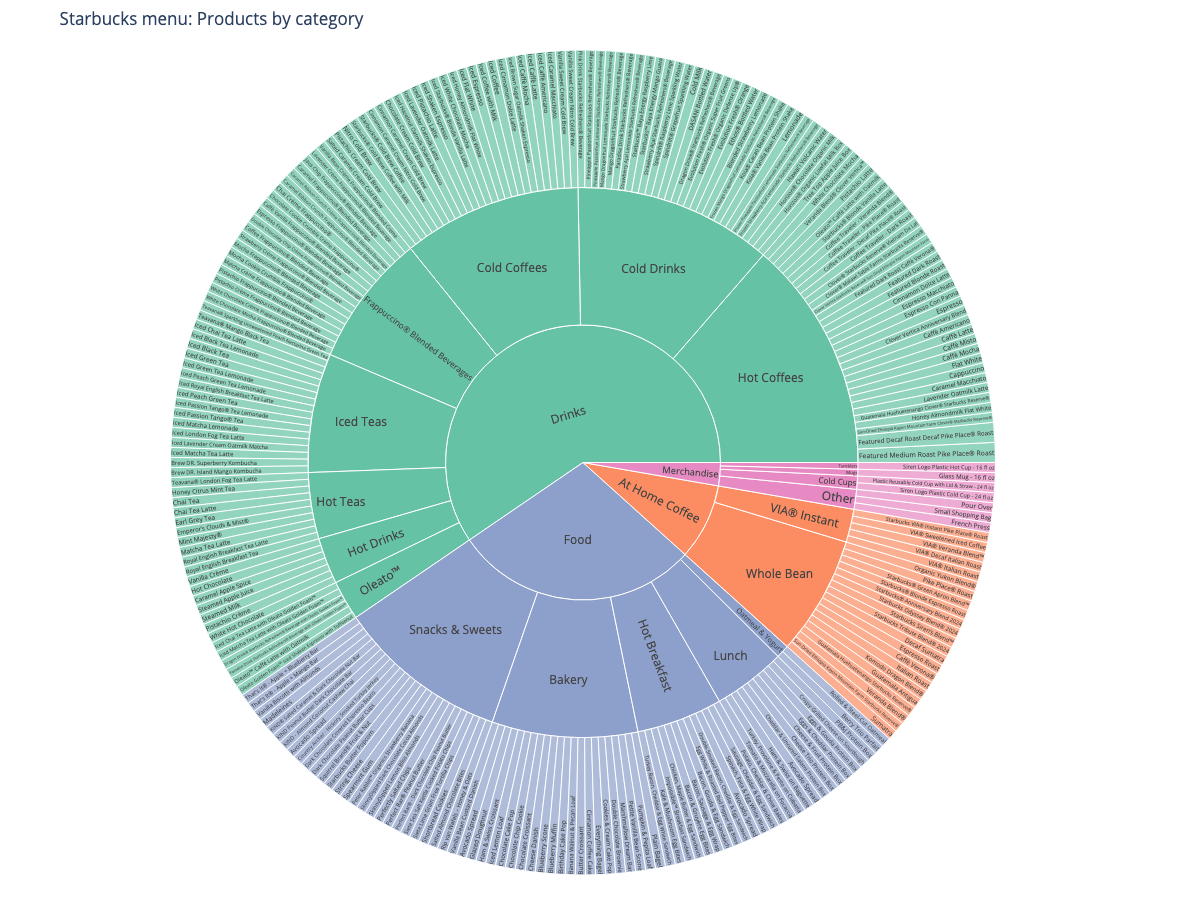

In [197]:
my_colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854"]

fig = px.sunburst(
    df,
    path=[
        "main_category",
        "sub_category",
        "product_name",
    ],
    color="main_category",
    color_discrete_sequence=my_colors,
    title="Starbucks menu: Products by category",
    width=900,
    height=900,
)
fig.update_layout(margin=dict(t=50, l=0, r=25, b=25))
fig.show()

In [220]:
hierarchical = (
    df.groupby(
        [
            "main_category",
            "product_type",
            "sub_category",
            # "product_form",
        ]
    )["product_name"]
    .count()
    .reset_index(name="count")
)

In [221]:
hierarchical.head()

,main_category,product_type,sub_category,count
0,At Home Coffee,Coffee,VIA® Instant,5
1,At Home Coffee,Coffee,Whole Bean,18
2,Drinks,Beverage,Cold Coffees,27
3,Drinks,Beverage,Cold Drinks,30
4,Drinks,Beverage,Frappuccino® Blended Beverages,20


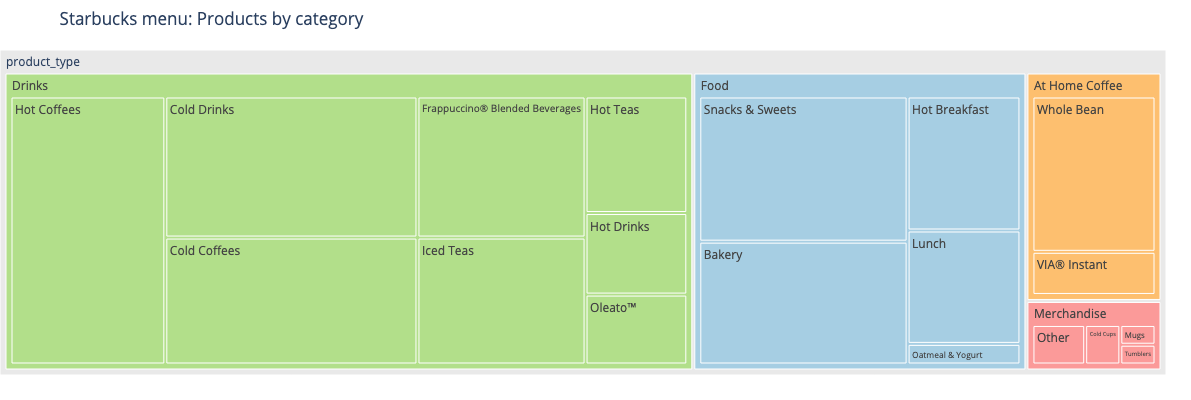

In [232]:
tree_colors = [
    "#a6cee3",
    "#b2df8a",
    "#fb9a99",
    "#fdbf6f",
    "#e9e9e9",
]

fig = px.treemap(
    hierarchical,
    path=[
        px.Constant("product_type"),
        "main_category",
        "sub_category",
    ],
    values="count",
    title="Starbucks menu: Products by category",
    color="main_category",
    color_discrete_sequence=tree_colors,
    width=800,
    height=400,
)
fig.update_layout(margin=dict(t=50, l=0, r=25, b=25))
fig.show()

---

## Exports

#### JSON

In [230]:
df.to_json("data/processed/starbucks_current_menu.json", indent=4, orient="records")

#### CSV

In [231]:
df.to_csv("data/processed/starbucks_current_menu.csv", index=False)